# Evaluation of the results from shapley-multiLogReg.dml

In [1]:
# To debug the shap package, or output more information during computation, clone the git repo and add its path here.
# This will prepend the local installation of shap and makes sure it is imported in the next cell.

%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('/home/louislepage/master/shap')) # or the path to your source code
sys.path.insert(0, module_path)

In [1]:
import pandas as pd
import numpy as np
import shap
import sklearn as sk
import time

In [3]:
#load prepared data into dataframe
df_x = pd.read_csv("../data/Adult_X.csv", header=None)
df_y = pd.read_csv("../data/Adult_y.csv", header=None)

In [4]:
#train model
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(df_x.values, df_y.values.ravel(), test_size=0.2, random_state=42)

model = sk.linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs')

model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [5]:
#test model
y_pred = model.predict(X_test)
accuracy = sk.metrics.accuracy_score(y_test, y_pred)
conf_matrix = sk.metrics.confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.8512206356517734
Confusion Matrix:
[[4617  325]
 [ 644  927]]


In [6]:
#create SHAP sampling explainer
sampling_explainer = shap.explainers.SamplingExplainer(model.predict, df_x.values)

#compute and measure time
def run_sampler_for(samples_per_feature):
      start = time.time()
      # Using n samples for each feature (107*n in total) to match systemds
      shap_vals_sampling=sampling_explainer.explain(df_x.iloc[1:2].values, nsamples=107*samples_per_feature, min_samples_per_feature=samples_per_feature)
      end = time.time()
      
      total_t=end-start
      print("The time of execution of sampling explainer is :",
            total_t, "s") 
      return shap_vals_sampling, total_t


In [11]:
shap_vals_sampling, _ = run_sampler_for(1000)

Samples per feature first round: 
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000]
Samples per feature second round:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
The time of execution of sampling explainer is : 67.85786247253418 s


In [12]:
# load results from systemds implementation
df_comp = pd.read_csv("../data/Adult_shap-values_10000smpl.csv", header=None, names=['systemds_shap'])

# add results from SHAP package
df_comp['python_shap']=shap_vals_sampling
df_comp.plot()

<Axes: >

<Figure size 640x480 with 1 Axes>

In [ ]:
import matplotlib.pyplot as plt
barWidth = 0.4  # Width of the bars
positions = np.arange(len(df_comp))

mse = sk.metrics.mean_squared_error(df_comp.python_shap, df_comp.systemds_shap)
print(mse)

plt.figure(figsize=(12,5))
plt.bar(positions-barWidth/2 , df_comp.systemds_shap, label="systemds", width=barWidth)
plt.bar(positions+barWidth/2 , df_comp.python_shap, label="SHAP package", width=barWidth)

plt.text(1, -0.24, 'MSE: '+str(mse))

# Additional plot formatting
plt.title('Shapley Values for the Adult Dataset (scaled)')
plt.xlabel('Index of transformencoded features\n (truncated larger than 70, since they were mostly zero)')
plt.ylabel('Shapley Value')
plt.xlim(0,70)

plt.legend()

In [7]:
time_results = pd.DataFrame()

python_times=np.zeros((10*3,2))
ind=0
for i in range(10):
      samples = 5000*(i+1)
      print("Running for "+str(samples)+" samples...")
      time_sum = 0
      for j in range(3):
            _ , total_time = run_sampler_for(samples)
            python_times[ind,0]=samples
            python_times[ind,1]=total_time
            ind +=1

python_times_df = pd.DataFrame(python_times)
python_times_df.to_csv("../data/python_runtimes.csv")


Running for 5000 samples...
Samples per feature first round: 
[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000
 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000
 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000
 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000
 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000
 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000
 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000 5000
 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Samples per feature second round:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
The time of execution of sampling explainer is : 73.07030034065247 s
Samples per feature first round: 
[5000 5000 5000 5000 5000 5000 5000 500

In [8]:
times_df=pd.read_csv("../data/systemds_runtimes.csv")
#load python times from file
python_times_df=pd.read_csv("../data/python_runtimes.csv")

30

In [10]:
times_df['runtime python'] = python_times_df.iloc[:,2]
#times_df = times_df.set_index('samples')
times_df

,samples,runtime,runtime python
0,5000,8.924,73.070300
1,5000,6.812,73.087010
2,5000,6.192,73.399806
3,10000,10.210,83.871438
4,10000,9.496,81.152004
5,10000,10.230,81.427823
6,15000,23.740,88.547574
7,15000,14.004,89.411645
8,15000,13.498,89.481126
9,20000,34.279,96.905461


<Axes: xlabel='samples'>

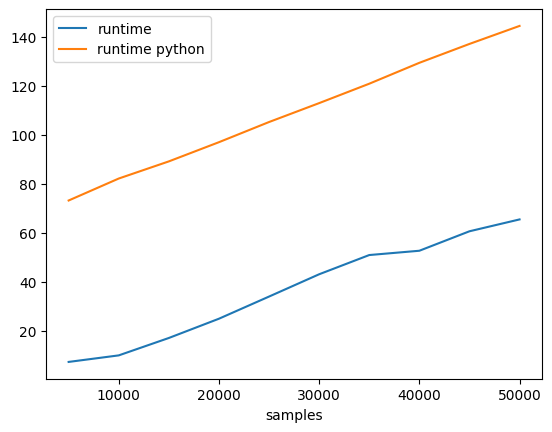

In [16]:
times_df.groupby('samples').mean().plot()